## **Solar Radiation Prediction**

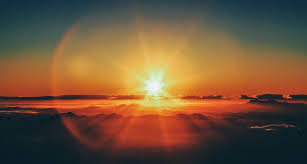

**Task from NASA Hackathon**

*Data was taken from: https://www.kaggle.com/dronio/SolarEnergy*




**Few words on solar radiation...**

Solar radiation (also known as solar resource) is a general term for the electromagnetic radiation emitted by the sun. Solar radiation can be captured and turned into useful forms of energy, such as heat and electricity, using a variety of technologies. 

The amount of solar radiation that reaches any one spot on the Earth's surface varies according to:

- Geographic location
- Time of day
- Season
- Local landscape
- Local weather

*(Retrived from https://www.energy.gov/eere/solar/articles/solar-radiation-basics)*

## **EDA**

In [1]:
# General tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from datetime import timedelta 

# For transformations and predictions
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split as split
from sklearn.feature_selection import SelectKBest, f_regression

# For scoring
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_squared_error as mse

# For the tree visualization
import pydot
from IPython.display import Image
from sklearn.externals.six import StringIO

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


Reading and presenting the data file:

In [2]:
data = pd.read_csv('SolarPrediction.csv', index_col='UNIXTime', parse_dates=['Data'])
data.head()

,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
UNIXTime,,,,,,,,,,
1475229326,2016-09-29,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1475229023,2016-09-29,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
1475228726,2016-09-29,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
1475228421,2016-09-29,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
1475228124,2016-09-29,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


The dataset includes observations of:

Solar Irradiance (W/m2)

Temperature (°F)

Barometric Pressure (Hg)

Humidity (%)

Wind Direction (°)

Wind Speed (mph)

Sun Rise/Set Time

Basic description of the data:

In [3]:
print('The data has {} records and {} columns'.format(data.shape[0],data.shape[1]))

The data has 32686 records and 10 columns


In [4]:
data.describe()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
count,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869
std,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474
min,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000
25%,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000
50%,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000
75%,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000
max,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000


Linear correlations and other relationships between variables:

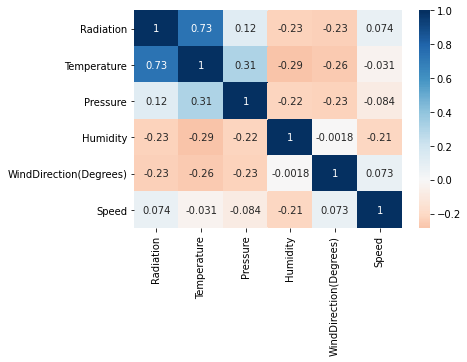

In [5]:
sns.heatmap(data.corr(), annot=True, cmap='RdBu', center=0)
plt.show()

- Strong correlation (0.73) was found between temperature to radiation.


- Relatively weak correlations were found between humidity and wind direction to radiation (|0.23|).


- Very weak correlations (<0.2) were found between pressure and the wind speed to radiation.  

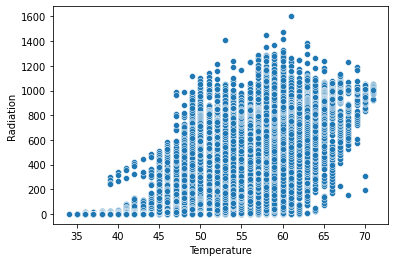

In [6]:
sns.scatterplot(x='Temperature', y='Radiation', data=data)
plt.show()

Changing columns of time into datetime format:

In [7]:
data['Time']= pd.to_datetime(data['Time'], format='%H:%M:%S') # Time of the sample
data['TimeSunRise']=pd.to_datetime(data['TimeSunRise'], format='%H:%M:%S') # Time of sunrise
data['TimeSunSet']=pd.to_datetime(data['TimeSunSet'], format='%H:%M:%S') # Time of sunset

Non- linear correlation:

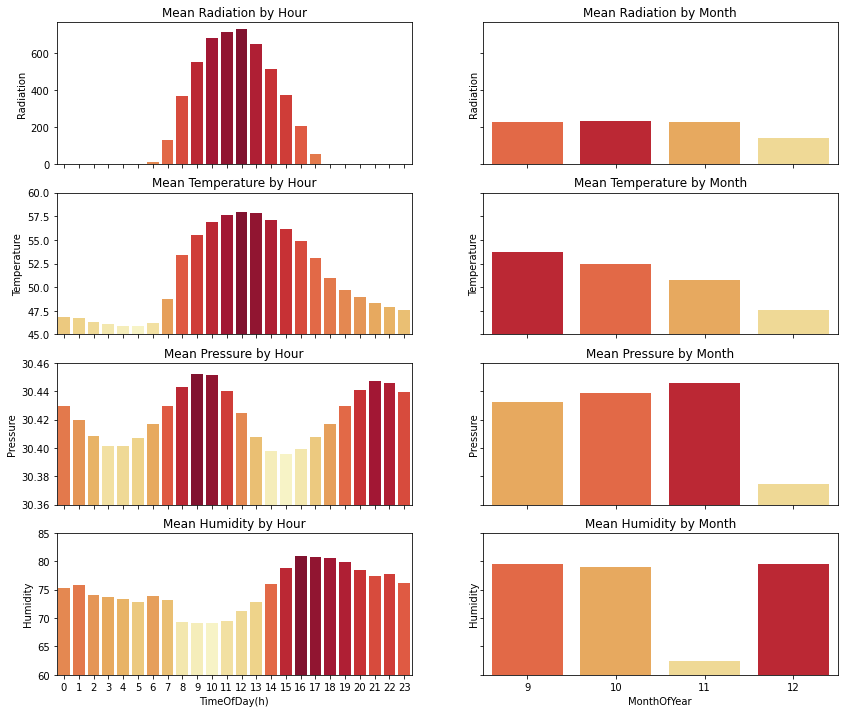

In [8]:
# Creating relevant columns:
data['MonthOfYear'] = data['Data'].dt.strftime('%m').astype(int) # Of the month
data['TimeOfDay(h)'] = data['Time'].dt.hour # Of the hour
data['TimeOfDay(s)']= data['Time'].dt.hour*60*60+ data['Time'].dt.minute*60+ data['Time'].dt.second

# Grouping data by month & hour:
grouped_m=data.groupby('MonthOfYear').mean().reset_index()
grouped_h=data.groupby('TimeOfDay(h)').mean().reset_index()

# Figure:
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots \
(4, 2, sharex='col', sharey='row', figsize=(14,12))

# Radiation:
ax1.set_title('Mean Radiation by Hour') 
pal = sns.color_palette("YlOrRd_r", len(grouped_h))
rank = grouped_h['Radiation'].argsort().argsort()
g = sns.barplot(x="TimeOfDay(h)", y='Radiation', data=grouped_h, palette=np.array(pal[::-1])[rank], ax=ax1)
ax1.set_xlabel('')

ax2.set_title('Mean Radiation by Month')
pal = sns.color_palette("YlOrRd_r", len(grouped_m))
rank = grouped_m['Radiation'].argsort().argsort() 
g = sns.barplot(x="MonthOfYear", y='Radiation', data=grouped_m, palette=np.array(pal[::-1])[rank], ax=ax2)
ax2.set_xlabel('')

# Temperature:
ax3.set_title('Mean Temperature by Hour')
pal = sns.color_palette("YlOrRd_r", len(grouped_h))
rank = grouped_h['Temperature'].argsort().argsort() 
g = sns.barplot(x="TimeOfDay(h)", y='Temperature', data=grouped_h, palette=np.array(pal[::-1])[rank], ax=ax3)
ax3.set_xlabel('')
ax3.set_ylim(45,60)

ax4.set_title('Mean Temperature by Month')
pal = sns.color_palette("YlOrRd_r", len(grouped_m))
rank = grouped_m['Temperature'].argsort().argsort() 
g = sns.barplot(x="MonthOfYear", y='Temperature', data=grouped_m, palette=np.array(pal[::-1])[rank], ax=ax4)
ax4.set_xlabel('')

# Pressure:
ax5.set_title('Mean Pressure by Hour')
pal = sns.color_palette("YlOrRd_r", len(grouped_h))
rank = grouped_h['Pressure'].argsort().argsort() 
g = sns.barplot(x="TimeOfDay(h)", y='Pressure', data=grouped_h, palette=np.array(pal[::-1])[rank], ax=ax5)
ax5.set_xlabel('')
ax5.set_ylim(30.36,30.46)

ax6.set_title('Mean Pressure by Month')
pal = sns.color_palette("YlOrRd_r", len(grouped_m))
rank = grouped_m['Pressure'].argsort().argsort() 
g = sns.barplot(x="MonthOfYear", y='Pressure', data=grouped_m, palette=np.array(pal[::-1])[rank], ax=ax6)
ax6.set_xlabel('')

# Humidity:
ax7.set_title('Mean Humidity by Hour')
pal = sns.color_palette("YlOrRd_r", len(grouped_h))
rank = grouped_h['Humidity'].argsort().argsort() 
g = sns.barplot(x="TimeOfDay(h)", y='Humidity', data=grouped_h, palette=np.array(pal[::-1])[rank], ax=ax7)
ax7.set_ylim(60,85)

ax8.set_title('Mean Humidity by Month')
pal = sns.color_palette("YlOrRd_r", len(grouped_m))
rank = grouped_m['Humidity'].argsort().argsort() 
g = sns.barplot(x="MonthOfYear", y='Humidity', data=grouped_m, palette=np.array(pal[::-1])[rank], ax=ax8)

plt.show()

Some conclusions:

1- Radiadtion is very related to hour, with maximum value at the noon (12am). It is almost constant among months, but a significant decreasing can be seen at December (winter...).

2- Temperature has strong relationships with both the hour and month (well, ofc...). Moreover, one can notice its distribution is very similar to that of the radiation (thus the strong correlation we presented previously).

3- Pressure has very narrow range of values (see the y-axis), creating a wave-like shape during the hours and it doesn't fit the radiation pattern among hours.

4- Humidity has the least organized distributions both relatively to hours and months. It may seems like negatively correlated with the rediation (but it's debatable).

## **Preprocessing**

First, we aimed to check the range of values for each varaible, for any exceptional data points.

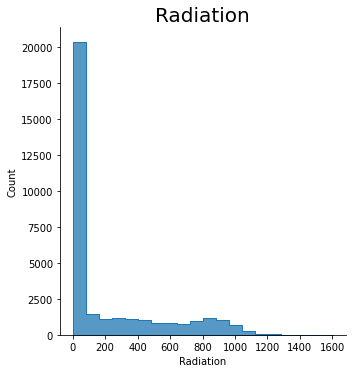

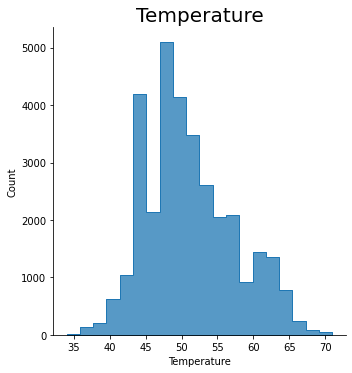

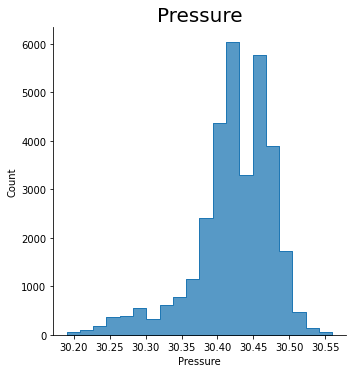

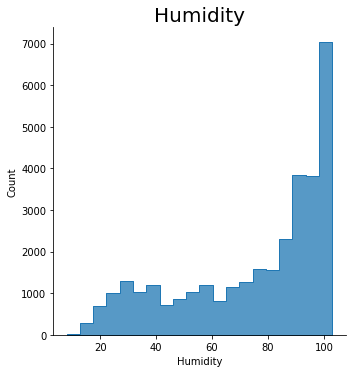

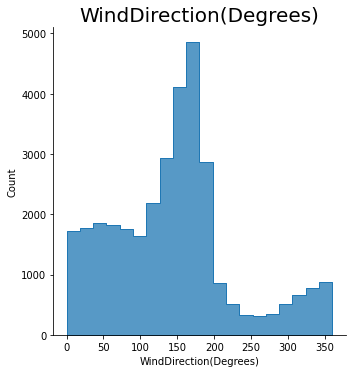

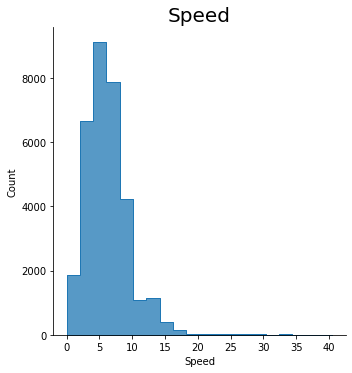

In [9]:
for col in data.drop(['MonthOfYear','TimeOfDay(h)', 'TimeOfDay(s)'], axis=1).select_dtypes(np.number).columns:
  sns.displot(data[col], bins=20, element="step")
  plt.title(col, size= 20)
  plt.show()

**Checking irregular values of the radiation**

In [10]:
data_extreme= data[data.Radiation>1100]  # Creating data frame for extreme radiation values(>1100)

# Temperature:
mean_temp_g= data['Temperature'].mean()
std_temp_g= data['Temperature'].std()
mean_temp_e=data_extreme['Temperature'].mean()
# Humidity:
mean_hum_g= data['Humidity'].mean()
std_hum_g= data['Humidity'].std()
mean_hum_e=data_extreme['Humidity'].mean()
# Wind Direction:
mean_winddir_g= data['WindDirection(Degrees)'].mean()
std_winddir_g= data['WindDirection(Degrees)'].std()
mean_winddir_e=data_extreme['WindDirection(Degrees)'].mean()
# Wind Speed:
mean_windspeed_g= data['Speed'].mean()
std_windspeed_g= data['Speed'].std()
mean_windspeed_e=data_extreme['Speed'].mean()

In [11]:
# Table of mean and std:
d = {'Temperature': [mean_temp_g, std_temp_g, mean_temp_e], 'Humidity': [mean_hum_g, std_hum_g,mean_hum_e],\
     'WindDirection': [mean_winddir_g, std_winddir_g, mean_winddir_e], 'Speed': [mean_windspeed_g, std_windspeed_g, mean_windspeed_e]}
df = pd.DataFrame(data=d, index=['mean_data', 'std', 'mean_extreme_data'])
df

,Temperature,Humidity,WindDirection,Speed
mean_data,51.103255,75.016307,143.489821,6.243869
std,6.201157,25.990219,83.167500,3.490474
mean_extreme_data,59.642276,82.634146,100.483821,6.702358


In [12]:
# Data frame:
Mean_df= pd.DataFrame({'Mean': [mean_temp_g, mean_temp_e,mean_hum_g,mean_hum_e, mean_winddir_g, mean_winddir_e,mean_windspeed_g, mean_windspeed_e],
                       'std': [round(std_temp_g,2), "", round(std_hum_g,2), "", round(std_winddir_g), "", round(std_windspeed_g,2), ""],
                       'Variable': ['Temperature','Temperature','Humidity','Humidity',"WindDirection",'WindDirection','Speed','Speed'],
                       'Type': ['General','Irregular','General','Irregular','General','Irregular','General','Irregular']
                       })

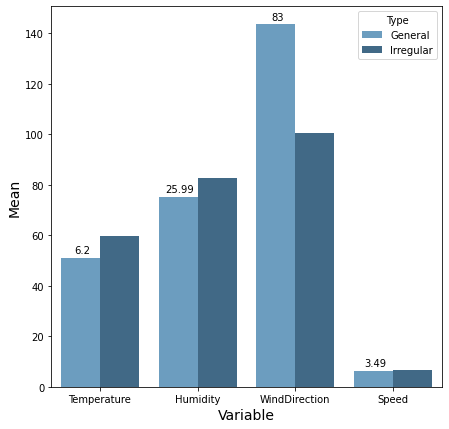

In [14]:
# Visualization:
g=sns.barplot(x='Variable', y='Mean',hue='Type', data= Mean_df, palette="Blues_d")
for index, row in Mean_df.iterrows():
    g.text(row.name-0.18-0.5*index, row.Mean+1.9, Mean_df['std'].iloc[index], color='black', ha="center")
g.figure.set_figwidth(7)
g.figure.set_figheight(7)
plt.xlabel('Variable', fontsize=14)
plt.ylabel('Mean', fontsize=14)
plt.show()

We have decided to keep all values, but scale the radiation into log values.

In [15]:
data['Radiation_log']= np.log1p(data['Radiation'])

## **Spliting the data**

In [16]:
# Independent variables:
X = data.drop(['Data', 'Time', 'TimeSunRise', 'TimeSunSet' \
               ,'MonthOfYear','Radiation', 'TimeOfDay(s)','Radiation','Radiation_log'], axis=1)
# Dependent variable:
y = data['Radiation_log']
# Spliting data to train and test datasets:
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=314159)
X_train.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeOfDay(h)
UNIXTime,,,,,,
1478599504,45,30.44,46,173.62,5.62,0
1479360602,48,30.44,66,121.37,5.62,19
1478096720,41,30.44,97,124.06,9.00,4
1481601001,49,30.32,101,263.55,12.37,17
1475461821,55,30.40,101,93.79,9.00,16


## **Scaling**

We chose to use *Standard Scaler*, due to the diverse distributions and wide ranges of values of the variables. Thus, we thought that using a scaler which consider the different standard deviations would be the best.

In [18]:
my_scaler = StandardScaler().fit(X_train)

X_train_scaled = pd.DataFrame(my_scaler.transform(X_train), index=X_train.index ,columns=X_train.columns)
X_test_scaled = pd.DataFrame(my_scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

X_train_scaled.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeOfDay(h)
UNIXTime,,,,,,
1478599504,-0.988034,0.306083,-1.106865,0.365133,-0.183290,-1.675387
1479360602,-0.504975,0.306083,-0.339725,-0.265892,-0.183290,1.070343
1478096720,-1.632114,0.306083,0.849343,-0.233405,0.791669,-1.097338
1481601001,-0.343955,-1.890533,1.002771,1.451220,1.763743,0.781319
1475461821,0.622164,-0.426122,1.002771,-0.598977,0.791669,0.636807


## **Linear Regression**

**Fitting the model:**


In [19]:
lin_model= LinearRegression().fit(X_train_scaled, y_train)

**Predicting the model:**

In [20]:
y_train_pred = lin_model.predict(X_train_scaled)

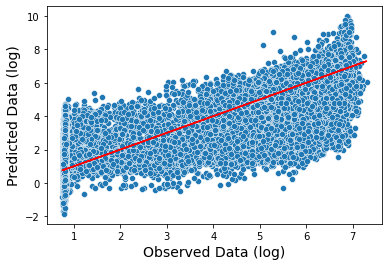

In [24]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')
ax.set_xlabel('Observed Data (log)', fontsize=14)
ax.set_ylabel('Predicted Data (log)', fontsize=14)
plt.show()

In [25]:
lin_RMSE = mse(y_train, y_train_pred)**0.5
lin_RMSE

1.5969918670103234

In [54]:
for i,col in enumerate(X_train_scaled.columns):
 print('The coefficient of {} is {}'.
       format(col,lin_model.coef_[i]))

The coefficient of Temperature is 2.0562109996698905
The coefficient of Pressure is -0.43879335737147745
The coefficient of Humidity is 0.24999612769245277
The coefficient of WindDirection(Degrees) is -0.189533531679844
The coefficient of Speed is 0.1650302197420478
The coefficient of TimeOfDay(h) is -0.3449319279419789


We can see that Temperature got the highest coeeficiant value, which is logical due to the strong linear correlation with radiation.

However, we may loss important data, for example the effect of hour on radiation. 

**Validation**

In [26]:
y_test_pred = lin_model.predict(X_test_scaled)

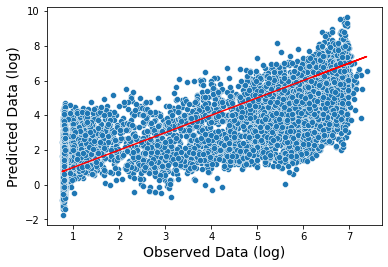

In [28]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')
ax.set_xlabel('Observed Data (log)', fontsize=14)
ax.set_ylabel('Predicted Data (log)', fontsize=14)
plt.show()

In [29]:
lin_RMSE_test = mse(y_test, y_test_pred)**0.5
lin_RMSE_test

1.6058623493558168

## **Decision Tree**

**Fitting the model:**

In [30]:
dt_model= DecisionTreeRegressor(max_leaf_nodes=10, max_depth=5).fit(X_train_scaled, y_train)

In [31]:
def visualize_tree(model, md):
    dot_data = StringIO()  
    export_graphviz(model, out_file=dot_data, feature_names=X_train.columns, max_depth=md,
                    filled=True, rounded=True,
                    special_characters=True)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
    return Image(graph.create_png(), width=800) 

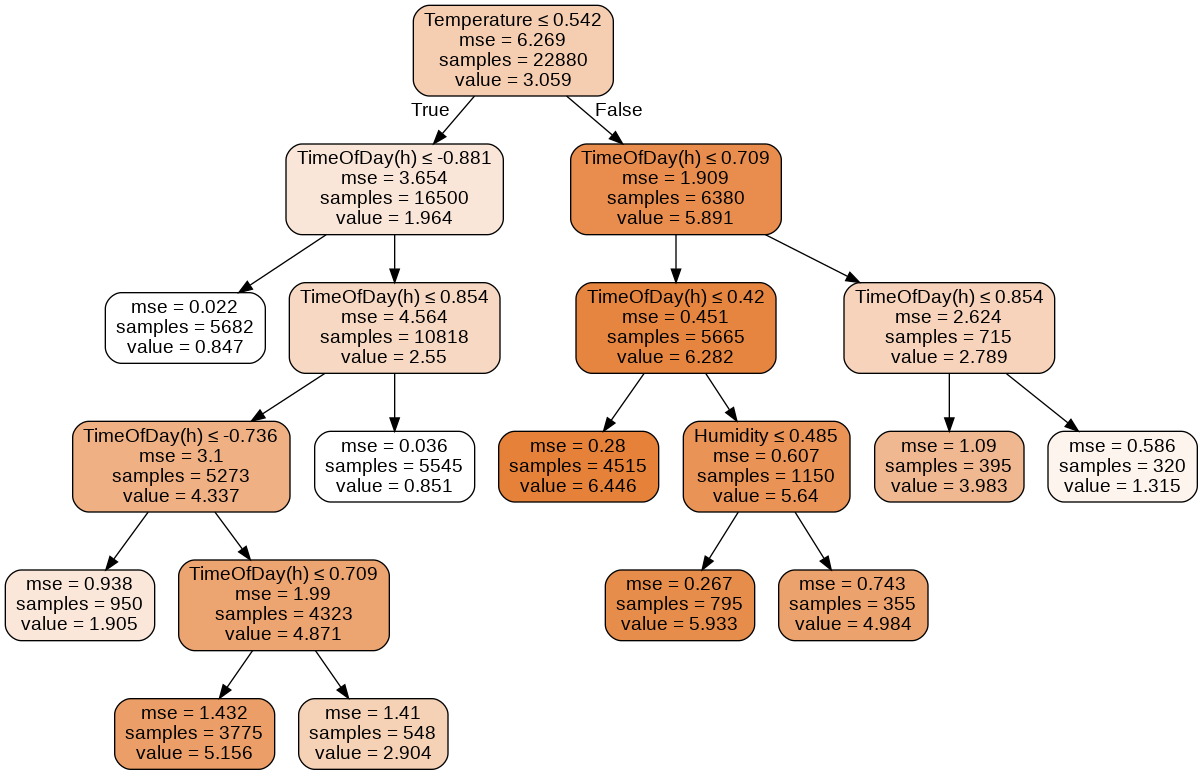

In [32]:
visualize_tree(dt_model, md=5)

For printing the model using web graphviz.com:

In [ ]:
# def print_dot_text(model):
#     dot_data = StringIO()
#     export_graphviz(model, out_file=dot_data, feature_names=X_train.columns)
#     dot_text = dot_data.getvalue()
#     print(dot_text)

# print_dot_text(dt_model)

**Predicting the model:**

In [33]:
y_train_pred = dt_model.predict(X_train_scaled)

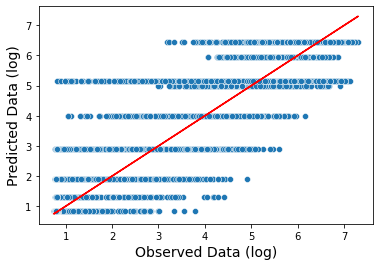

In [36]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')
ax.set_xlabel('Observed Data (log)', fontsize=14)
ax.set_ylabel('Predicted Data (log)', fontsize=14)
plt.show()

In [37]:
dt_RMSE = mse(y_train, y_train_pred)**0.5
dt_RMSE

0.6526274676120084

**Validation**

In [38]:
y_test_pred = dt_model.predict(X_test_scaled)

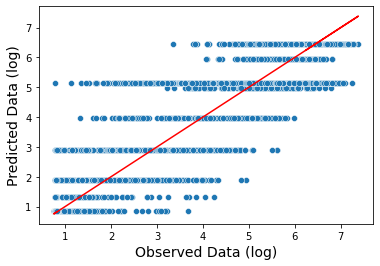

In [40]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')
ax.set_xlabel('Observed Data (log)', fontsize=14)
ax.set_ylabel('Predicted Data (log)', fontsize=14)
plt.show()

In [41]:
dt_RMSE_test = mse(y_test, y_test_pred)**0.5 
dt_RMSE_test

0.662987213748644

## **k-nearest neighbors regressor**

In [42]:
KN_model= KNeighborsRegressor(n_neighbors=15).fit(X_train_scaled, y_train)

In [43]:
y_train_pred = KN_model.predict(X_train_scaled)

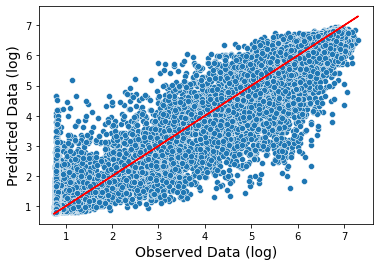

In [45]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')
ax.set_xlabel('Observed Data (log)', fontsize=14)
ax.set_ylabel('Predicted Data (log)', fontsize=14)
plt.show()

In [46]:
KNN_RMSE = mse(y_train, y_train_pred)**0.5 
KNN_RMSE

0.5905007259138986

**Validation**

In [47]:
y_test_pred = KN_model.predict(X_test_scaled)

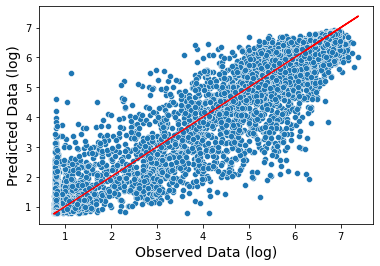

In [49]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')
ax.set_xlabel('Observed Data (log)', fontsize=14)
ax.set_ylabel('Predicted Data (log)', fontsize=14)
plt.show()

In [50]:
KNN_RMSE_test = mse(y_test, y_test_pred)**0.5 
KNN_RMSE_test

0.6306025807310778

## **Best model**

In [51]:
# Data frame:

RMSE_df= pd.DataFrame({'RMSE': [lin_RMSE,dt_RMSE,KNN_RMSE,lin_RMSE_test,dt_RMSE_test,KNN_RMSE_test],
                       'Model': ['Linear Regression','Decision Tree','KN neighbors','Linear Regression','Decision Tree','KN neighbors'],
                       'Type': ['Train','Train','Train','Test','Test','Test']
                       })

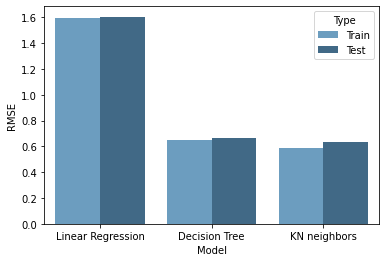

In [52]:
# Visualization:
sns.barplot(x='Model', y='RMSE',hue='Type', data= RMSE_df, palette="Blues_d")
plt.show()

### **Thank you!**